# The Plug-and-Chug Notebook for Ethogram-Making:
## This notebook includes:
   ### 1. Re-encoding videos
   ### 2. Creating inferences (label) on your videos using an existing SLEAP model and exporting the coordinates in an .h5 file
   - you can also do the inferences and exporting the coordinates in the SLEAP application. When running the inferences in the SLEAP app, depending on if and what error message you get, you may need to **re-encode your videos** 
   ### 3. Getting Behavioral Syllables




This notebook does not include:
   - how to create and train a SLEAP model
   - how to create and train a Keypoint Moseq model



First, let's get your packages imported so we can use them in our code. A list of packages that you need to install in your environment is in the README.txt file. Remember **importing =/= installing** (I've made this silly mistake multiple times when sleep deprived)

environment location: C:\Users\Steve\anaconda3\envs\keypoint_moseq

In [2]:
import os
import subprocess #this is how you are going to use FFmpeg. also, installation of the FFmpeg "package" is different from other packages


Also get your file paths set up:

In [4]:
beforereencodingvidfolder_dir = 'C:/Users/Steve/Desktop/Karin/test/before/' #put None if you don't want to reencode
video_dir = 'C:/Users/Steve/Desktop/Karin/copyingthetutorial/videos'#change directory of output folder here for the videos and h5 files
sleap_model_path = 'C:/Users/Steve/Desktop/Karin/tutorials/240709_092906.multi_instance.n=1301/' #where is your SLEAP model?
project_dir = 'C:/Users/Steve/Desktop/Karin/copyingthetutorial'

kpmsmodel_name = '2024_07_02-16_16_37' #what is the name of your keypoint moseq model? (not the file path)


# beforereencodingvidfolder_dir = 'C:/Users/Steve/Desktop/Karin/test/before/' #put None if you don't want to reencode
# video_dir = 'C:/Users/Steve/Desktop\Karin/katiesvideosmodeling/keypointmoseqwork/videos' #change directory of output folder here for the videos and h5 files
# sleap_model_path = 'C:/Users/Steve/Desktop/Karin/tutorials/240709_092906.multi_instance.n=1301/' #where is your SLEAP model?
# project_dir = 'C:/Users/Steve/Desktop/Karin/katiesvideosmodeling/keypointmoseqwork/'

# kpmsmodel_name = '2024_07_12-11_12_32' #what is the name of your keypoint moseq model? (not the file path)

# 1. Re-encoding videos
A common problem with SLEAP are videos that are [not reliably seekable](https://sleap.ai/develop/help.html). In my experience, sometimes when I want to run inferences, SLEAP will print out an error in the error log saying something about an issue with the last frame of the video. I've had this issue with a few videos on the Grid (but somehow not Katie's) and it has to do with how the video data is stored (I'm pretty sure). One of the things you can to trouble shoot is re-encoding. Something to note is that re-encoding ***changes your file***, and personally, I'm a believer of the "less is more" approach when it comes to any post-collection modifying of data. 

Anyways, here is a function that will reencode your videos in the '''beforereencodingvidfolder_dir''' folder directory

In [4]:
def reencode_videos(beforereencodingvidfolder_dir, video_dir):
    if beforereencodingvidfolder_dir is None or not os.path.exists(beforereencodingvidfolder_dir):
        print('no reencoding today!')
        return
    else:
        # Ensure output directory exists
        os.makedirs(video_dir, exist_ok=True)

        # FFmpeg command template
        ffmpeg_command = 'ffmpeg -y -i "{input_file}" -c:v libx264 -pix_fmt yuv420p -preset superfast -crf 23 "{output_file}"'

        # Iterate through each file in beforevidfolder_dir
        for filename in os.listdir(beforereencodingvidfolder_dir):
            if filename.endswith('.mp4'):
                input_file = os.path.join(beforereencodingvidfolder_dir, filename)
                output_file = os.path.join(video_dir, filename)
                
                # Construct and execute FFmpeg command
                command = ffmpeg_command.format(input_file=input_file, output_file=output_file)
                
                try:
                    subprocess.run(command, shell=True, check=True)
                    print(f'Reencoded {filename} and saved as {os.path.basename(output_file)}')
                except subprocess.CalledProcessError as e:
                    print(f'Error reencoding {filename}: {e}')

Here is the code to execute said function

In [5]:
reencode_videos(beforereencodingvidfolder_dir, video_dir)


Reencoded NBL3_post_home_20241001_10.avi.mp4 and saved as NBL3_post_home_20241001_10.avi.mp4


# 2. Creating inferences (A.K.A. labeling) on your videos using an existing SLEAP model and exporting the 2D coordinates in an .h5 file
At this point you are going to have to change the kernel to "sleap" (whomp whomp) because for some reason I can't do it for you. Believe me, I tried for like an hour. Basically, I couldn't install Keypoint Moseq in the same environment as SLEAP which is why you need to change kernels.

*Anyways*... I wrote a few lines that will run in the terminal to basically generate labels in an .slp file (SLEAP file) and an .h5 file based off of the model that you set 'sleap_model_path' to earlier. The .h5 file is what you will use for classifying the behaviors in your videos. 

You change kernels by clicking "select kernel" in the top right corner 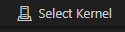 and you will get a drop down menu on the top-middle part of the ribbon. Select the one named "sleap" (or the one with the sleap library in it).
##### TLDR: If you started running this notebook in a different kernel, now is the time to ***change your kernel to sleap***. Also, since changing kernels will reset your variables, ***re-run the cell where you imported your packages and the cell where you specified your file/folder paths***



So this first cell is for SLEAP labeling your videos and printing a .slp file (yes it will take awhile)

In [4]:
max_tracks = 1 #number of animals you are tracking
tracker = 'simplemaxtracks'
for filename in os.listdir(video_dir):
    if filename.endswith('.mp4'):
        input_file = os.path.join(video_dir, filename)
        output_filename = os.path.splitext(filename)[0] + '.slp'
        output_file_path = os.path.join(video_dir, output_filename)
        sleap_track_command = f"sleap-track -m {sleap_model_path} " \
                              f"--tracking.tracker {tracker} " \
                              f"--tracking.max_tracking {1} " \
                              f"--tracking.max_tracks {max_tracks} " \
                              f"-o {output_file_path} " \
                              f"{input_file}"
        try:
                # Execute the command
                subprocess.run(sleap_track_command, shell=True, check=True)
        except subprocess.CalledProcessError as e:
            print(f'Error processing {filename}: {e}')


This next cell will convert the .slp files to .h5 files

In [5]:
for filename in os.listdir(video_dir):
    if filename.endswith('.slp'):
        input_slpfile = os.path.join(video_dir, filename)
        output_h5filename = os.path.splitext(filename)[0] + '.h5'
        output_h5file_path = os.path.join(video_dir, output_h5filename)
        sleap_convert_command = f"sleap-convert --format analysis -o {output_h5file_path} {input_slpfile}"
        try:
            subprocess.run(sleap_convert_command)
        except subprocess.CalledProcessError as e:
            print(f'Error processing {filename}: {e}')

# 3. Getting Behavioral Syllables
This...figuring out this section was the bane of my existence.

-+

You have to change your kernel again (whomp whomp) to the one with the keypoint moseq library installed

In [5]:
import os
import subprocess #this is how you are going to use FFmpeg. also, installation of the FFmpeg "package" is different from other packages
import keypoint_moseq as kpms

c:\Users\Steve\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:20: UserWarning:

Using Panel interactively in VSCode notebooks requires the jupyter_bokeh package to be installed. You can install it with:

   pip install jupyter_bokeh

or:
    conda install jupyter_bokeh

and try again.



In [6]:
# load the most recent model checkpoint and pca object
model = kpms.load_checkpoint(project_dir, kpmsmodel_name)[0]

In [7]:
for filename in os.listdir(video_dir):
    if filename.endswith('.h5'):
        print(filename)

dL43_D7_pupretrieval_20240705_01.avi.h5
logi_sleap_copy1105frames.025_dL31_P0_pupretrieval_20240104_08.avi.analysis.h5


In [22]:
config = lambda: kpms.load_config(project_dir)
for filename in os.listdir(video_dir):
    if filename.endswith('.h5'):
        # Load keypoints, confidences, and body parts
        coordinates, confidences, bodyparts = kpms.load_keypoints(os.path.join(video_dir, filename), 'sleap')
        data, metadata = kpms.format_data(coordinates, confidences, **config())
        # apply saved model to new data
        results = kpms.apply_model(model, data, metadata, project_dir, kpmsmodel_name, **config())
        kpms.save_results_as_csv(results, project_dir, kpmsmodel_name)

Applying model: 100%|███████████████| 500/500 [1:43:30<00:00, 12.42s/it]


Saved results to C:/Users/Steve/Desktop/Karin/copyingthetutorial\2024_
07_02-16_16_37\results.h5


Loading keypoints: 100%|█████████████████| 1/1 [00:00<00:00, 100.42it/s]
c:\Users\Steve\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\util.py:836: UserWarning:


Coordinates for the following bodyparts are missing (set to NaN) in at least 50.0% of frames:
 - tailEnd



c:\Users\Steve\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\util.py:842: UserWarning:

This may cause problems during modeling. See https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#high-proportion-of-nans for additional information.

Applying model: 100%|█████████████████| 500/500 [32:27<00:00,  3.89s/it]


Saved results to C:/Users/Steve/Desktop/Karin/copyingthetutorial\2024_
07_02-16_16_37\results.h5


Saving to csv: 100%|██████████████████████| 1/1 [00:00<00:00, 47.76it/s]


If you want to sort your videos by mutant animal and wild-type you can do it here:

In [10]:
kpms.interactive_group_setting(project_dir, kpmsmodel_name)

Row
    [0] Tabulator(editors={'name': None, ...}, show_index=False, titles={'name': 'recording name',...}, value=              ..., widths={'name': 400})
    [1] Column
        [0] Button(button_type='primary', name='Save group info')

to get a table that tells you when an animal is doing a particular syllable at each frame, you can do that here. also i'm pretty sure when onset is true, that indicates that it is the frame that a behavior starts.

In [13]:
moseq_df = kpms.compute_moseq_df(project_dir, kpmsmodel_name, smooth_heading=True) 
moseq_df

,name,centroid_x,centroid_y,heading,angular_velocity,velocity_px_s,syllable,frame_index,group,onset
0,dL43_D7_pupretrieval_20240705_01.avi,533.991068,233.928963,-0.694815,0.000000,0.000000,85,0,default,True
1,dL43_D7_pupretrieval_20240705_01.avi,534.496896,233.268519,-0.694815,-2.319673,24.956827,85,1,default,False
2,dL43_D7_pupretrieval_20240705_01.avi,533.446866,232.262817,-0.486744,-5.688007,43.618806,85,2,default,False
3,dL43_D7_pupretrieval_20240705_01.avi,533.361561,232.620734,-0.487418,-10.877924,11.038273,85,3,default,False
4,dL43_D7_pupretrieval_20240705_01.avi,532.361961,231.694631,-2.774471,-14.665500,40.880086,85,4,default,False
...,...,...,...,...,...,...,...,...,...,...
13090,logi_sleap_copy1105frames.025_dL31_P0_pupretri...,115.852772,281.457508,1.888517,-0.622756,17.129347,65,3276,default,False
13091,logi_sleap_copy1105frames.025_dL31_P0_pupretri...,118.497088,280.889733,1.872378,-0.655734,81.137538,65,3277,default,False
13092,logi_sleap_copy1105frames.025_dL31_P0_pupretri...,120.440815,279.611425,1.735521,-0.611214,69.792058,65,3278,default,False
13093,logi_sleap_copy1105frames.025_dL31_P0_pupretri...,122.109964,279.884130,1.735521,-0.475948,50.738375,65,3279,default,False


and now to save it as a .csv file:

In [14]:
# save moseq_df
save_dir = os.path.join(project_dir, kpmsmodel_name) # directory to save the moseq_df dataframe
moseq_df.to_csv(os.path.join(save_dir, 'moseq_df.csv'), index=False)
print('Saved `moseq_df` dataframe to', save_dir)

Saved `moseq_df` dataframe to C:/Users/Steve/Desktop/Karin/copyingthetutorial\2024_07_02-16_16_37


this can give you some information about the syllables i'm pretty sure:

In [11]:
stats_df = kpms.compute_stats_df(
    project_dir,
    kpmsmodel_name,
    moseq_df, 
    min_frequency=0.005,       # threshold frequency for including a syllable in the dataframe
    groupby=['group', 'name'], # column(s) to group the dataframe by
    fps=30)                    # frame rate of the video from which keypoints were inferred

stats_df

,group,name,syllable,heading_mean,heading_std,heading_min,heading_max,angular_velocity_mean,angular_velocity_std,angular_velocity_min,angular_velocity_max,velocity_px_s_mean,velocity_px_s_std,velocity_px_s_min,velocity_px_s_max,frequency,duration
0,default,dL43_D7_pupretrieval_20240705_01.avi,4,-0.299016,NaN,-0.299016,-0.299016,-0.932937,NaN,-0.932937,-0.932937,113.392350,NaN,113.392350,113.392350,0.025641,0.033333
1,default,dL43_D7_pupretrieval_20240705_01.avi,5,-1.170478,1.376755,-3.140830,3.139985,-0.488635,18.437977,-188.301218,188.336553,61.204844,69.046564,1.417688,392.722083,0.205128,3.900000
2,default,dL43_D7_pupretrieval_20240705_01.avi,21,1.564603,2.031649,-3.020777,3.079622,0.640574,1.236732,-1.647422,3.838410,47.004984,50.196273,2.484602,221.995873,0.076923,1.355556
3,default,dL43_D7_pupretrieval_20240705_01.avi,26,-0.214103,NaN,-0.214103,-0.214103,-1.235023,NaN,-1.235023,-1.235023,264.889471,NaN,264.889471,264.889471,0.025641,0.033333
4,default,dL43_D7_pupretrieval_20240705_01.avi,33,-1.338181,2.363133,-3.009168,0.332807,0.878304,0.013430,0.868808,0.887801,266.775605,102.992011,193.949256,339.601955,0.051282,0.033333
5,default,dL43_D7_pupretrieval_20240705_01.avi,54,0.345159,NaN,0.345159,0.345159,1.774218,NaN,1.774218,1.774218,164.140168,NaN,164.140168,164.140168,0.025641,0.033333
6,default,dL43_D7_pupretrieval_20240705_01.avi,65,0.112121,2.008171,-3.140659,3.141370,0.089373,13.435812,-188.029446,188.279391,51.343435,53.798463,0.790664,457.439059,0.282051,18.909091
7,default,dL43_D7_pupretrieval_20240705_01.avi,85,0.448579,1.874126,-3.139125,3.138211,-0.091794,13.683675,-187.906900,188.126759,76.932414,72.038204,0.000000,413.452971,0.256410,8.186667
8,default,dL43_D7_pupretrieval_20240705_01.avi,92,2.871790,0.163327,2.700427,3.116129,-0.128636,0.399390,-0.969355,0.474945,46.474894,51.053227,3.165575,209.266427,0.025641,1.800000
9,default,dL43_D7_pupretrieval_20240705_01.avi,99,-1.815955,NaN,-1.815955,-1.815955,1.346016,NaN,1.346016,1.346016,51.403221,NaN,51.403221,51.403221,0.025641,0.033333


aaaand you can also save it:

In [ ]:
# save stats_df
save_dir = os.path.join(project_dir, kpmsmodel_name)
stats_df.to_csv(os.path.join(save_dir, 'stats_df'), index=False)
print('Saved `stats_df` dataframe to', save_dir)